# Классификация текстов с использованием Наивного Байесовского Классификатора

## Задание 1 (1 балл)

Откройте данные. Узнайте, сколько в них спам- и не спам-писем. Визуализируйте полученные соотношение подходящим образом.

In [164]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_curve, auc
from sklearn.naive_bayes import ComplementNB, MultinomialNB
import matplotlib.pyplot as plt


In [5]:
# откройте данные: ваш код здесь
df = pd.read_csv('./data/spam_or_not_spam.csv')
df.head()


,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMBER NUMBER from chris garrigues cwg dated NUMBER NUMBERfaNUMBERd deepeddy com message id NUMBER NUMBER tmda deepeddy vircio com i can t reproduce this error for me it is very repeatable like every time without fail this is the debug log of the pick happening NUMBER NUMBER NUMBER pick_it exec pick inbox list lbrace lbrace subject ftp rbrace rbrace NUMBER NUMBER sequence mercury NUMBER NUMBER NUMBER exec pick inbox list lbrace lbrace subject ftp rbrace rbrace NUMBER NUMBER sequence mercury NUMBER NUMBER NUMBER ftoc_pickmsgs NUMBER hit NUMBER NUMBER NUMBER marking NUMBER hits NUMBER NUMBER NUMBER tkerror syntax error in expression int note if i run the pick command by hand delta pick inbox list lbrace lbrace subject ftp rbrace rbrace NUMBER NUMBER sequence mercury NUMBER hit that s where the NUMBER hit comes from obviously the version of nmh i m using is delta pick version pick nmh NUMBER NUMBER NUMBER compiled on URL at sun mar NUMBER NUMBER NUMBER NUMBER ict NUMBER and the relevant part of my mh_profile delta mhparam pick seq sel list since the pick command works the sequence actually both of them the one that s explicit on the command line from the search popup and the one that comes from mh_profile do get created kre ps this is still using the version of the code form a day ago i haven t been able to reach the cvs repository today local routing issue i think _______________________________________________ exmh workers mailing list exmh workers URL URL,0
1,martin a posted tassos papadopoulos the greek sculptor behind the plan judged that the limestone of mount kerdylio NUMBER miles east of salonika and not far from the mount athos monastic community was ideal for the patriotic sculpture as well as alexander s granite features NUMBER ft high and NUMBER ft wide a museum a restored amphitheatre and car park for admiring crowds are planned so is this mountain limestone or granite if it s limestone it ll weather pretty fast yahoo groups sponsor NUMBER dvds free s p join now URL to unsubscribe from this group send an email to forteana unsubscribe URL your use of yahoo groups is subject to URL,0
2,man threatens explosion in moscow thursday august NUMBER NUMBER NUMBER NUMBER pm moscow ap security officers on thursday seized an unidentified man who said he was armed with explosives and threatened to blow up his truck in front of russia s federal security services headquarters in moscow ntv television reported the officers seized an automatic rifle the man was carrying then the man got out of the truck and was taken into custody ntv said no other details were immediately available the man had demanded talks with high government officials the interfax and itar tass news agencies said ekho moskvy radio reported that he wanted to talk with russian president vladimir putin police and security forces rushed to the security service building within blocks of the kremlin red square and the bolshoi ballet and surrounded the man who claimed to have one and a half tons of explosives the news agencies said negotiations continued for about one and a half hours outside the building itar tass and interfax reported citing witnesses the man later drove away from the building under police escort and drove to a street near moscow s olympic penta hotel where authorities held further negotiations with him the moscow police press service said the move appeared to be an attempt by security services to get him to a more secure location yahoo groups sponsor NUMBER dvds free s p join now URL to unsubscribe from this group send an email to forteana unsubscribe URL your use of yahoo groups is subject to URL,0
3,klez the virus that won t die already the most prolific virus ever klez continues to wreak havoc andrew brandt from the september NUMBER issue of pc world magazine posted thursday august NUMBER NUMBER the klez worm is approaching its seventh month of wriggling across the web making it one of the mos

In [72]:
# рассчитайте частоты для классов : ваш код здесь
label_balance = pd.DataFrame({'count': df['label'].value_counts()})
label_balance = label_balance.rename({0: 'not_spam', 1: 'spam'})
label_balance['%'] = round(label_balance['count'] /
                           label_balance['count'].sum(), 4)
label_balance


,count,%
not_spam,2500,0.8333
spam,500,0.1667


''

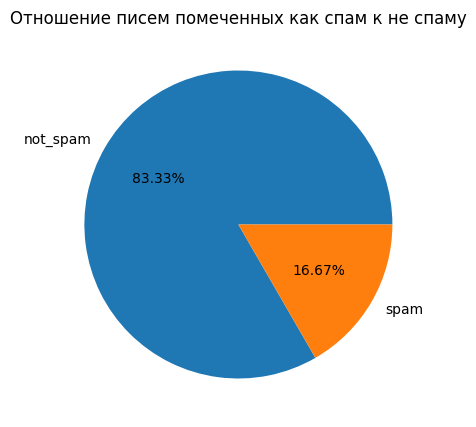

In [68]:
# визуализируйте результат: ваш код здесь
fig, axes = plt.subplots(figsize=(10, 5))
pie = plt.pie(
    label_balance['count'],
    labels=label_balance.index,
    autopct='%.2f%%',

)
axes.set_title('Отношение писем помеченных как спам к не спаму')


## Задание 2 (2 балла)

Вам необходимо предобработать ваши данные и перевести их в векторный вид. Подгрузим необходимый модуль:

In [73]:
from sklearn.feature_extraction.text import CountVectorizer


Замените в данных все пустые строки и строки, состоящие из пробелов, на пропуски (NaN). После этого удалите из данных все строки, в которых наблюдаются пропущенные значения.

In [111]:
# ваш код здесь
df = df.replace(['', ' '], np.nan)
df.dropna(axis=0, inplace=True)


Переводим данные в векторный вид:

In [113]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df["email"])


Определите, сколько теперь признаков в нашем наборе данных:

In [122]:
# ваш код здесь
print(f'{X.shape[1]} признаков после обработки')


34116 признаков после обработки


## Задание 3 (2 балла)

Определите целевую переменную и признаки:

In [123]:
# ваш код здесь
y = df['label']


Разделите выборку на обучающую и тестовую, используя стратифицированное разбиение (параметр `stratify` установите в значение вектора ответов y) размер тестовой выборки (`test_size`) возьмите как 0.25, параметр `random_state` определите со значением 42:

In [125]:
# ваш код здесь
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42)


Рассчитайте среднее значение целевой переменной по тестовой выборке:

In [128]:
# ваш код здесь
y_test.mean().round(3)


0.165

## Задание 4 (3 балла)

1) Определите и обучите подходящий алгоритм с параметром alpha = 0.01

2) Оцените результат с точки зрения всех известных вам метрик (не менее трёх):

In [135]:
# Multinomial
classificator_multi = MultinomialNB(alpha=0.01)
classificator_multi.fit(X_train, y_train)

multi_pred = classificator_multi.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, multi_pred).round(3)}')
print(f'Precision: {precision_score(y_test, multi_pred).round(3)}')
print(f'F1-score: {f1_score(y_test, multi_pred).round(3)}')


Accuracy: 0.987
Precision: 1.0
F1-score: 0.958


In [136]:
# Complement
classificator_comp = ComplementNB(alpha=0.01)
classificator_comp.fit(X_train, y_train)

comp_pred = classificator_comp.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, comp_pred).round(3)}')
print(f'Precision: {precision_score(y_test, comp_pred).round(3)}')
print(f'F1-score: {f1_score(y_test, comp_pred).round(3)}')


Accuracy: 0.988
Precision: 1.0
F1-score: 0.962


Нарисуйте ROC-кривую:

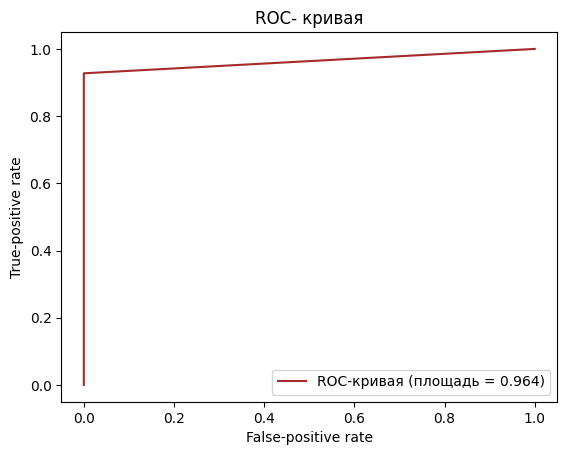

In [163]:
# ваш код здесь
fpr, tpr, thresholds = roc_curve(y_test, comp_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='brown', label=f'ROC-кривая (площадь = {roc_auc.round(3)})')
plt.title('ROC- кривая')
plt.xlabel('False-positive rate')
plt.ylabel('True-positive rate')
plt.legend(loc="lower right")
plt.show();

## Задание 5 (3 балла)

Переберите несколько значений alpha с помощью кросс-валидации. Оцените, зависит ли от этого параметра качество классификации.

In [166]:
# ваш код здесь
param_grid = {'alpha': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}

grid_search = GridSearchCV(
    estimator=ComplementNB(),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred).round(3)}')
print(f'Precision: {precision_score(y_test, y_pred).round(3)}')
print(f'F1-score: {f1_score(y_test, y_pred).round(3)}')
print(f'Best params: {grid_search.best_params_}')

Accuracy: 0.995
Precision: 0.992
F1-score: 0.984
Best params: {'alpha': 0.2}


> Подбор параметров по сетке позволил выявить улучшение качества классификации, зависящее от параметра alpha